# Using a Pre-Trained VGG-16 Conv-net to find a peacock

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `numpy`, `matplotlib`, `skimage`, `torch`, `torch.nn`, `torch.nn.functional` and `torchvision`.

Our `utils` module provides an image preparation function.

In [2]:
import os, time
import numpy as np
from matplotlib import pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
import skimage.transform, skimage.util

import imagenet_classes
import utils


## Setup device

Choose the first CUDA device `cuda:0`:

In [3]:
torch_device = torch.device('cuda:0')

## Load an image to process

In [4]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
original_img = plt.imread(IMAGE_PATH)
original_img = skimage.util.img_as_float(original_img)

The peacock is approximately 900 x 900 pixels in size; about four times too big, so scale the image down by a factor of 4:

In [5]:
img = skimage.transform.rescale(original_img, 1.0 / 4.0, preserve_range=True)

D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Show it:

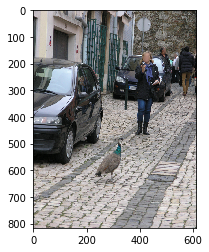

In [6]:
plt.imshow(img)
plt.show()

## Build the network

The `torchvision` package provides a number of pre-trained classification models, one of which is VGG-16.

In [7]:
# Build it, requesting that the pre-trained model weights are loaded
# The call to the `to` method moves it onto the GPU
vgg16_net = torchvision.models.vgg.vgg16(pretrained=True).to(torch_device)

# Call the eval() method; we are not training
vgg16_net.eval()

# Also, set a variable 
MODEL_MEAN = np.array([0.485, 0.456, 0.406])
MODEL_STD = np.array([0.229, 0.224, 0.225])

## Define a function for classifying an image

In [8]:
def f_classify_images(image_batch):
    """
    image_batch - images as a NumPy 4D array - (sample, channel, height, width)
    return: probabilities - (sample, class)
    """
    # We don't need gradients here as we are only performing inference/prediction
    with torch.no_grad():
        x = torch.tensor(image_batch, dtype=torch.float, device=torch_device)
        logits = vgg16_net(x)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()
    

This time, prepare the image but *do not* scale and crop, since we want to extract 224x224 regions of the image in a sliding window fashion:

In [9]:
raw_img, img_for_vgg = utils.prepare_image(img, MODEL_MEAN, MODEL_STD, image_size=None)

Use `skimage.util.view_as_windows` to extract 224 x 224 sliding windows from the image, stepping by 32 pixels. The window shape is `(1,3,224,224)` - 1 sample, 3 channels, 224 x 224 pixels. The step is `(1,3,32,32)`; this will ensure that we will get only one window in the sample and channel dimensions, with as many as needed in the Y and X dimensions.

In [10]:
PRED_STEP = 32

image_windows = skimage.util.view_as_windows(img_for_vgg, (1,3,224,224), (1,3,PRED_STEP,PRED_STEP))
pred_shape = image_windows.shape[2:4]
print(image_windows.shape)

D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\util\shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


(1, 1, 19, 13, 1, 3, 224, 224)


The result is an 8-dimensional array; the dimensions are (sample_window, channel_window, Y_window, X_window, sample, channel, Y, X).

Collapse first 5 dimensions into the sample dimension:

In [11]:
image_windows = image_windows.reshape((-1, 3, 224, 224))
print(image_windows.shape)

(247, 3, 224, 224)


Lets take a look at a few of the extracted windows:

D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


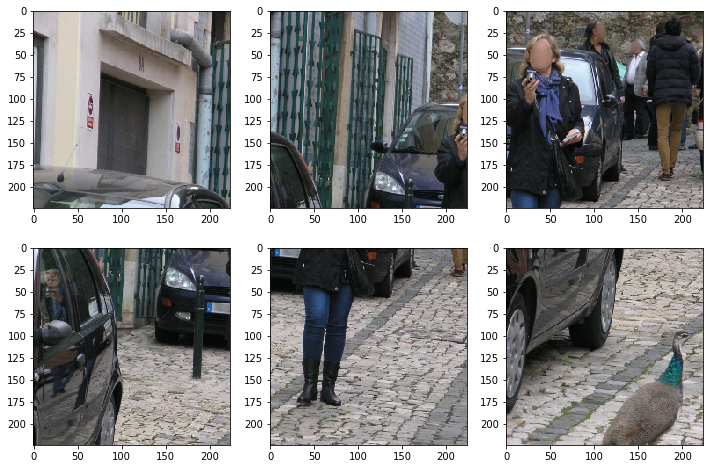

In [12]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(utils.inv_prepare_image(image_windows[i*32], MODEL_MEAN, MODEL_STD))
plt.show()

### Predict probabilities for the 224x224 patches.

Predicting 532 images in one go will use too much GPU memory, so predict them 16 at a time:

In [26]:
t1 = time.time()
pred_prob_flat = [f_classify_images(image_windows[i:i+16,:,:,:]) for i in range(0, image_windows.shape[0], 16)]
t2 = time.time()
pred_prob_flat = np.concatenate(pred_prob_flat, axis=0)

print('Prediction for {} images took {:.2f}s, resulting in an array of shape{}'.format(image_windows.shape[0],
                                                                                      t2-t1, pred_prob_flat.shape))

Prediction for 247 images took 0.58s, resulting in an array of shape(247, 1000)


So we can visualise the predictions, lets reshape the predictions back into two dimensions. The variable `pred_shape` contains the 2D shape of the predicted output:

In [14]:
pred_prob_2d = pred_prob_flat.reshape(pred_shape + (1000,))
print(pred_prob_2d.shape)

(19, 13, 1000)


Use `numpy.argmax` to choose the predicted class and visualise the classes:

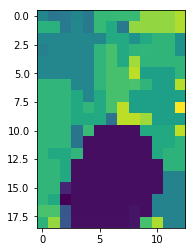

In [15]:
pred_cls_2d = np.argmax(pred_prob_2d, axis=2)
plt.imshow(pred_cls_2d)
plt.show()

Its not easy to interpret, but sort of interesting.
Lets take a look at the image classes that were found in the photo:

In [16]:
# Get the unique values in the `pred_cls_2d` array
classes = np.unique(pred_cls_2d.flatten())

for c in classes:
    # Make a mask that selects the region that has this prediction
    mask_2d = pred_cls_2d == c
    # Select the probabilities chosen by the mask then choose the probability of the chosen class
    prob = pred_prob_2d[mask_2d,:][:,c]
    # Print the class index, name and maximum probability
    print('{}. {}  --  {:.2f}%'.format(c, imagenet_classes.IMAGENET_CLASSES[c], np.max(prob) * 100.0))

48. Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis  --  15.65%
84. peacock  --  100.00%
85. quail  --  36.46%
99. goose  --  28.67%
145. king penguin, Aptenodytes patagonica  --  18.55%
298. mongoose  --  15.34%
399. abaya  --  9.68%
408. amphibian, amphibious vehicle  --  20.28%
412. ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin  --  7.48%
420. banjo  --  9.82%
424. barbershop  --  12.78%
428. barrow, garden cart, lawn cart, wheelbarrow  --  10.24%
450. bobsled, bobsleigh, bob  --  26.14%
460. breakwater, groin, groyne, mole, bulwark, seawall, jetty  --  62.03%
471. cannon  --  16.67%
475. car mirror  --  91.11%
523. crutch  --  11.10%
568. fur coat  --  29.32%
608. jean, blue jean, denim  --  35.47%
609. jeep, landrover  --  33.38%
612. jinrikisha, ricksha, rickshaw  --  38.01%
637. mailbox, letter box  --  7.10%
646. maze, labyrinth  --  36.79%
652. military uniform  --  21.33%
656. minivan  --  4

There are some unlikely choices there; such as `861. toilet seat`. Luckily they have low predicted probabilities. Lets isolate the peacock class and visualise:

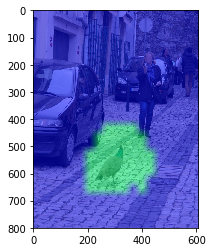

In [17]:
mask_2d = pred_cls_2d == 84  
# One prediction pixel accounts for 32 image pixels. A 224x224 window therefore covers 7 prediction pixels. So put 3px
# padding around the prediction so that we can align it with the original image:
mask_2d = np.pad(mask_2d, [(3, 3), (3, 3)], mode='constant')
# Scale up by a factor of 32 so that we can superimpose the prediction on top of the original:
mask_2d = skimage.transform.rescale(mask_2d, 32)

# SHow it:
plt.imshow(raw_img)
plt.imshow(mask_2d, cmap='winter', alpha=0.5)
plt.show()

## Using convolutions to find the peacock more efficiently

We found the peacock by extracting 224x224 windows from the image in a sliding window fashion and classifying each window individually. This is very wasteful however as adjacent windows will share most of their input data. We can take advantage of the fact that the network uses convolutions in its earlier layers to run the network against the complete image in one go, generating a 2D prediction 'field', rather than a single prediction.

There is one wrinkle however. The last layers are fully-connected (or linear) layers. These need to be converted to convolutional layers. It turns out that fully-connected layers are mathematically equivalent to convolutional layers that take their entire input field and convolve it with a kernel of the same size, resulting in a 1x1 output. In VGG-16, the layer `fc6` takes a 512-channel 7x7 input and produces a single 4096-channel output; this is functionally equivalent to a convolutional layer with a 7x7 kernel. Further fully-connected layers that take a single multi-channel input and produce a single multi-channel output can be seen as convolutional layers that take a 1x1 input and produce a 1x1 output, only combining channels with one another. These are functionally equivalent to a convolution with a 1x1 kernel. Such layers are called 'Network-in-Network' [1] layers.

How do we convert a fully-connected layer to a convolutional layer? It turns out that it is rather easy. We need to use the weights and biases in the right way. The biases are easy as we can use them as is; the per-unit biases of a fully connected layer become per channel biases of a convolutional layer. It turns out that the weights are easy too; we can also use them as-is, although a little explanation would be a good idea.

Consider the layer `fc6` from VGG-16. It takes a 512-channel 7x7 input and produces a single 4096-channel output. Each output channel will have 512x7x7 weights; one to modulate each channel of each pixel. Recall that the image array is in the order `(sample, channel, height, width)`. Weights are shared between samples, so the fully-connectd layer does the following (following the source code of PyTorch [`nn.Linear`](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py) and [`F.linear`](https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py)):

```
image_flattened = img.view(-1, 512*7*7)             # reshape to (sample, channel*height*width)
                                                    # note weights are of shape (channel_out, channel_in)
                                                    
output = image_flattened.matmul(weights.t()) + bias # (sample, chan_height_width) @ (chan_height_width, channel_out)
                                                    # (note that the weights are transposed)
                                                    # output shape is (sample, 4096)
```

The input data is in the right order; we just flatten out the last dimensions before the dot-product. What about a convolutional layer? Convolution kernel weights have the shape `(channel_out, channel_in, kernel_height, kernel_width)`, so converting the weights of a fully-connected/`Linear` layer for use in a convolutional layer is just a reshape:

- Linear layer weights start as `(channel_out, channel_in)`, interpreted as `(channel_out, chan_height_width_in)`
- Separate out input channels: `(channel_out, chan_height_width_in)` -> `(chan_out, chan_in, krn_height, krn_width)`

Lets create a network that will operate in convolutional fashion. We will use the `torchvision` [implementation of VGG-16](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py) as reference.

We declare a network class that inherits from PyTorch `nn.Module`. We borrow the `features` attribute from the original VGG-16 model; this gets us the convolutional layers from the original VGG-16 model. We build a `nn.Sequential` module -- as in the original -- but using convolutional layers. We then copy the weights over.

In [18]:
class VGG16ConvModel (nn.Module):
    def __init__(self, vgg16):
        super(VGG16ConvModel, self).__init__()
        # Get the convolutional layers
        self.features = vgg16.features
        
        # New classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=(7, 7)),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Conv2d(4096, 1000, kernel_size=1),
        )
        
        # The fc6, fc7 and final layers have the same indices as the convolutional
        # layers as above
        fc6 = vgg16.classifier[0]
        fc7 = vgg16.classifier[3]
        final = vgg16.classifier[6]
        self.classifier[0].weight.data = fc6.weight.data.view(4096, 512, 7, 7)
        self.classifier[0].bias.data = fc6.bias.data
        self.classifier[3].weight.data = fc7.weight.data.view(4096, 4096, 1, 1)
        self.classifier[3].bias.data = fc7.bias.data
        self.classifier[6].weight.data = final.weight.data.view(1000, 4096, 1, 1)
        self.classifier[6].bias.data = final.bias.data
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
 

Instantiate it and move onto the GPU:

In [19]:
# Build the new model
vgg16_conv_model = VGG16ConvModel(vgg16_net).to(torch_device)

vgg16_conv_model.eval()

VGG16ConvModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

Build a convenience function for the new network:

In [20]:
def f_classify_images_conv(image_batch):
    """
    image_batch - images as a NumPy 4D array - (sample, channel, height, width)
    return: probabilities - (sample, class, height, width)
    """
    # We don't need gradients here as we are only performing inference/prediction
    with torch.no_grad():
        x = torch.tensor(image_batch, dtype=torch.float, device=torch_device)
        logits = vgg16_conv_model(x)
        # We still normalize over dimension 1
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

Now predict and time it:

In [28]:
t1 = time.time()
pred_prob_conv = f_classify_images_conv(img_for_vgg)
t2 = time.time()

print('Prediction for {} images took {:.2f}s, resulting in an array of shape{}'.format(img_for_vgg.shape,
                                                                                      t2-t1, pred_prob_conv.shape))

Prediction for (1, 3, 816, 612) images took 0.06s, resulting in an array of shape(1, 1000, 19, 13)


#### ^^^ *NOTE THE 10x speedup and that everything fit into RAM* ^^^

Compute the predicted classes using `numpy.argmax`:

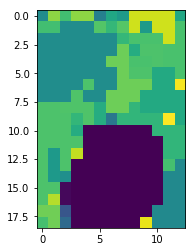

In [22]:
pred_cls_conv = np.argmax(pred_prob_conv[0,:,:,:], axis=0)
plt.imshow(pred_cls_conv)
plt.show()

The results aren't identical.

Find the peacock once again:

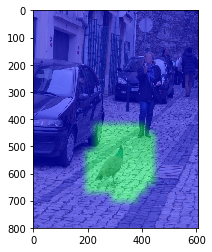

In [23]:
mask_2d = pred_cls_conv == 84  
# One prediction pixel accounts for 32 image pixels. A 224x224 window therefore covers 7 prediction pixels. So put 3px
# padding around the prediction so that we can align it with the original image:
mask_2d = np.pad(mask_2d, [(3, 3), (3, 3)], mode='constant')
# Scale up by a factor of 32 so that we can superimpose the prediction on top of the original:
mask_2d = skimage.transform.rescale(mask_2d, 32)

# SHow it:
plt.imshow(raw_img)
plt.imshow(mask_2d, cmap='winter', alpha=0.5)
plt.show()

Let's see what we found:

In [24]:
# Get the unique values in the `pred_cls_2d` array
classes = np.unique(pred_cls_conv.flatten())

for c in classes:
    # Make a mask that selects the region that has this prediction
    mask_2d = pred_cls_conv == c
    # Select the probabilities chosen by the mask then choose the probability of the chosen class
    prob = pred_prob_conv[0][:,mask_2d][c,:]
    # Print the class index, name and maximum probability
    print('{}. {}  --  {:.2f}%'.format(c, imagenet_classes.IMAGENET_CLASSES[c], np.max(prob) * 100.0))

84. peacock  --  99.99%
85. quail  --  8.89%
102. echidna, spiny anteater, anteater  --  8.07%
298. mongoose  --  9.25%
360. otter  --  4.71%
399. abaya  --  6.12%
428. barrow, garden cart, lawn cart, wheelbarrow  --  9.81%
460. breakwater, groin, groyne, mole, bulwark, seawall, jetty  --  22.81%
471. cannon  --  16.51%
475. car mirror  --  90.08%
479. car wheel  --  6.59%
511. convertible  --  22.31%
518. crash helmet  --  7.80%
559. folding chair  --  11.75%
568. fur coat  --  29.60%
575. golfcart, golf cart  --  15.78%
576. gondola  --  17.17%
608. jean, blue jean, denim  --  15.59%
609. jeep, landrover  --  18.03%
612. jinrikisha, ricksha, rickshaw  --  13.05%
637. mailbox, letter box  --  9.32%
646. maze, labyrinth  --  13.90%
652. military uniform  --  12.99%
656. minivan  --  36.51%
661. Model T  --  27.98%
665. moped  --  7.24%
670. motor scooter, scooter  --  7.59%
704. parking meter  --  25.01%
706. patio, terrace  --  6.73%
743. prison, prison house  --  9.73%
744. projectil

## References

[1] Lin, Min, Qiang Chen, and Shuicheng Yan. "Network in network." arXiv preprint arXiv:1312.4400 (2013).